## Import libraris

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../')
from utilities.ML_algorithms import create_RF_model, create_XGB_model, create_ANN_model
from utilities.plot_results import plot_prediction, plot_scores, plot_feature_importance

## Read data train

In [2]:
cs_file = '../data/SMB_input_four_ERA5.csv'

df_train = pd.read_csv(cs_file, delimiter='\t', index_col=['Date'], parse_dates=['Date'], na_values='NAN')


## Relabel stakes

In [3]:
df_train.reset_index(inplace=True)
df_train = df_train.sort_values(by = ['Elevation', 'Date'], ascending=True).reset_index()

In [4]:
label_stake = df_train.drop_duplicates(subset=['Elevation']).reset_index()[['Elevation', 'Stake']]
label_stake

,Elevation,Stake
0,96.8,PG19
1,121.0,PG09
2,131.4,PG18
3,159.1,PG08
4,167.2,PG17
5,188.6,PG07
6,194.5,PG16_AWS
7,223.7,PG06
8,229.4,PG16
9,247.9,PG05


In [5]:
label_stake_mod = label_stake.copy()
label_stake_mod.index = label_stake_mod['Elevation']
range_elev = np.arange(90,470, 30)
range_elev[-1] = range_elev[-1] + 30
range_elev

array([ 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 480])

In [6]:
grupos_ele = []
for i in range(len(range_elev)-1):
    print(i)
    grupos_ele.append(label_stake_mod.loc[range_elev[i]:range_elev[i+1]])

0
1
2
3
4
5
6
7
8
9
10
11


In [7]:
for i in range(len(grupos_ele)):
    df_train['Stake'].replace(grupos_ele[i]['Stake'].values.tolist(), 'G'+str(i), inplace = True)

In [8]:
print(df_train)

      index       Date Stake   Latitude  Longitude  Elevation  Days   SMB  \
0      1177 2010-12-05    G0 -62.237672 -58.633624       96.8    13  0.13   
1      1178 2010-12-11    G0 -62.237672 -58.633624       96.8     6  0.20   
2      1179 2010-12-23    G0 -62.237672 -58.633624       96.8    12 -0.21   
3      1180 2011-01-09    G0 -62.237672 -58.633624       96.8    17 -0.59   
4      1181 2011-01-25    G0 -62.237672 -58.633624       96.8    16  0.25   
...     ...        ...   ...        ...        ...        ...   ...   ...   
1288    580 2012-01-27   G11 -62.199141 -58.581200      465.6   324  2.19   
1289    581 2013-02-16   G11 -62.199141 -58.581200      465.6   386 -0.01   
1290    582 2013-02-19   G11 -62.199141 -58.581200      465.6     3 -0.01   
1291    583 2013-02-27   G11 -62.199141 -58.581200      465.6     8 -0.05   
1292    584 2013-03-06   G11 -62.199141 -58.581200      465.6     7  0.13   

           t2m         rh         u2       SWin       LWin        tp  \
0  

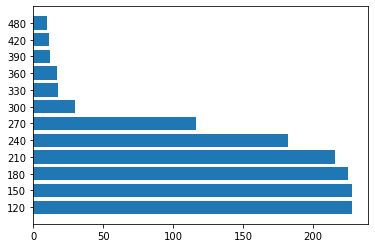

In [9]:
fig, ax = plt.subplots()
ax.barh(np.arange(len(range_elev)-1), df_train['Stake'].value_counts().values)
ax.set_yticks(np.arange(len(range_elev)-1))
ax.set_yticklabels(range_elev[1:])
print()

In [10]:
label_stake = df_train.drop_duplicates(subset=['Stake']).reset_index(drop=True)[['Stake']]
label_stake

,Stake
0,G0
1,G1
2,G2
3,G3
4,G4
5,G5
6,G6
7,G7
8,G8
9,G9


## Folds to train

In [11]:
random_stake1 = np.arange(0,6,1)
random_stake2 = np.sort(np.arange(6,12,1))[::-1]
index_test = np.stack((random_stake1, random_stake2), axis=1)
index_test

array([[ 0, 11],
       [ 1, 10],
       [ 2,  9],
       [ 3,  8],
       [ 4,  7],
       [ 5,  6]])

### Create matrix of indexes (6 folds)

In [12]:
custom_cv = []
for i in range(len(index_test)):
    data_train_index = df_train.loc[df_train['Stake'].isin(label_stake.drop(index_test[i])['Stake'].values)]
    data_test_index  = df_train.loc[df_train['Stake'].isin(label_stake.loc[index_test[i]]['Stake'].values)]
    custom_cv.append((np.array(data_train_index.index), np.array(data_test_index.index)))

## Read data test

In [13]:
cs_file = '../data/SMB_input_belli_ERA5.csv'
df_test = pd.read_csv(cs_file, delimiter='\t', index_col=['Date'], parse_dates=['Date'], na_values='NAN')
features_to_drop = ['Stake', 'Latitude','Longitude', 'SMB']
X_test = (df_test.drop(features_to_drop, axis=1)).to_numpy()
y_test = (df_test['SMB'].copy()).to_numpy()

## Convert train dataframe to array

In [14]:
df_train.columns

Index(['index', 'Date', 'Stake', 'Latitude', 'Longitude', 'Elevation', 'Days',
       'SMB', 't2m', 'rh', 'u2', 'SWin', 'LWin', 'tp', 'sf', 'msl', 'press',
       'tcc', 't2m_an', 'PDD'],
      dtype='object')

In [15]:
features_to_drop = ['index','Date', 'Stake', 'Latitude','Longitude', 'SMB']

df_train_X = (df_train.drop(features_to_drop, axis=1)) 
X = (df_train.drop(features_to_drop, axis=1)).to_numpy()
y = (df_train['SMB'].copy()).to_numpy()


## Lasso train

In [16]:
cv_model_lasso = LassoCV(cv=custom_cv).fit(X, y)
cv_model_lasso

LassoCV(cv=[(array([ 116,  117,  118, ..., 1278, 1279, 1280]),
             array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,...
       1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144,
       1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155,
       1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166,
       1167, 1168, 1169, 1170, 1

### Evaluation Lasso with glaciar test data (Bellin)

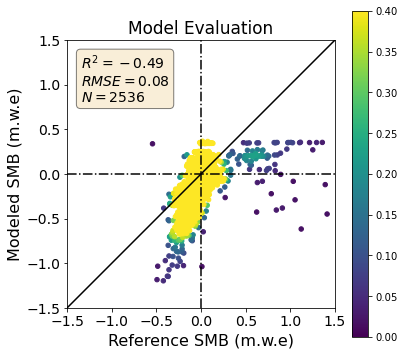

In [17]:
plot_prediction(y_test, cv_model_lasso.predict(X_test), len(y_test), n_toplot=5000 )
print()

## RF train

In [18]:
RF_model = create_RF_model(custom_cv).fit(X, y)

In [19]:
RF_model.best_params_

{'n_estimators': 600, 'min_samples_leaf': 5, 'max_features': 4, 'max_depth': 8}

### Evaluation RF with glaciar test data (Bellin)

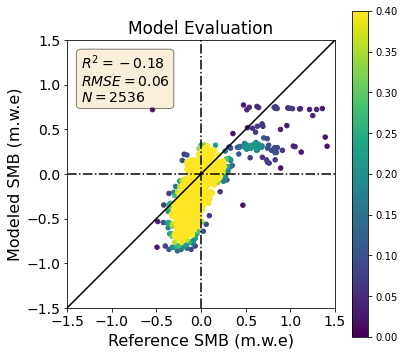

In [20]:
fig = plot_prediction(y_test, RF_model.predict(X_test), len(y_test), n_toplot=5000 )

<Figure size 432x216 with 0 Axes>

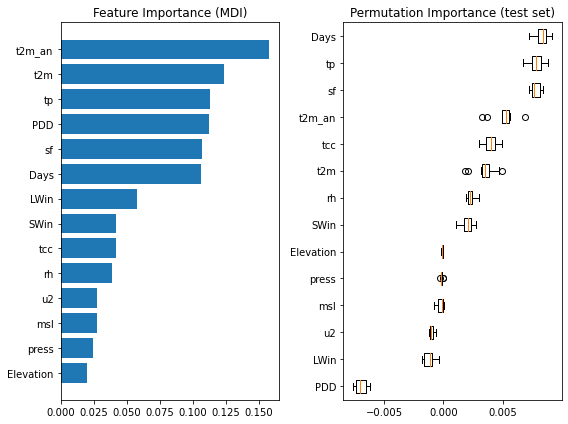

In [21]:
fig = plot_feature_importance(RF_model, df_train_X, X_test, y_test)

## XGBoot train

In [22]:
XGB_model = create_XGB_model(custom_cv).fit(X, y)

In [23]:
XGB_model.best_params_

{'n_estimators': 300,
 'min_samples_leaf': 40,
 'max_features': 4,
 'max_depth': 4}

### Evaluation XGBoot with glaciar test data (Bellin)

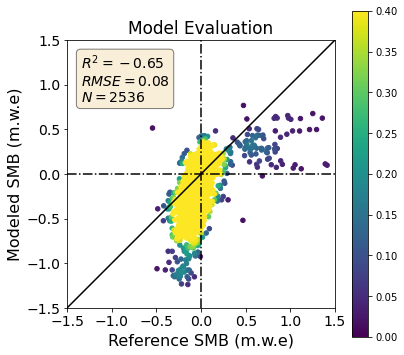

In [24]:
fig = plot_prediction(y_test, XGB_model.predict(X_test), len(y_test), n_toplot=5000 )

<Figure size 432x216 with 0 Axes>

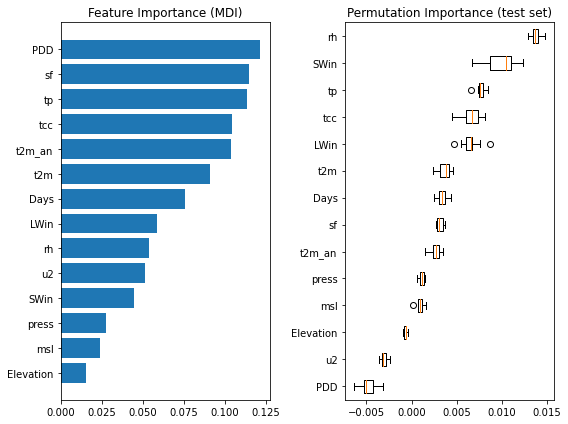

In [25]:
fig = plot_feature_importance(XGB_model, df_train_X, X_test, y_test)

## Train ANNs

In [26]:
scaler = StandardScaler().fit(X)
ANN_model = create_ANN_model(custom_cv).fit(scaler.transform(X), y)

/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Conv

In [27]:
ANN_model.best_params_

{'validation_fraction': 0.001,
 'solver': 'adam',
 'shuffle': True,
 'max_iter': 250,
 'learning_rate': 'constant',
 'hidden_layer_sizes': 50,
 'batch_size': 150,
 'alpha': 0.0005,
 'activation': 'tanh'}

### Evaluation ANN with glaciar test data (Bellin)

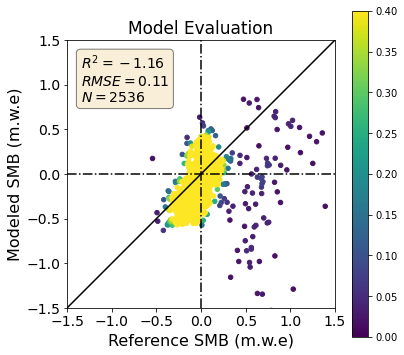

In [28]:
fig = plot_prediction(y_test, ANN_model.predict(scaler.transform(X_test)), len(y_test), n_toplot=5000)

In [29]:
#plot_feature_importance(MLP_gridCV, df_train_X, X_test, y_test)
#print()